In [1]:
#Préparation des données 
using CSV, DataFrames
using CounterfactualExplanations
using CounterfactualExplanations.Models
using TaijaData
using TaijaPlotting
using Random
using Plots
using MLJ
using MLJScikitLearnInterface

# Upload CSV file
df = CSV.read("brfss13.csv", DataFrame)

#Transformation of non-digital features
label_map = Dict("No" => 1, "Yes" => 2)
#df.Diabetes = [label_map[x] for x in df.Diabetes]
#df.Kidney = [label_map[x] for x in df.Kidney]
#df.Stroke = [label_map[x] for x in df.Stroke]

#smoking_map = Dict("Every day" => 1, "Some days" => 2, "Not at all" =>3)
#df.Smoking = [smoking_map[x] for x in df.Smoking]
#gender_map = Dict("Female" => 1, "Male" => 2)
#df.Gender = [gender_map[x] for x in df.Gender]

# Keep only the feature and target
features = ["BMI", "Alcohol", "Exercise", "Fruit", "Sleep", "Diabetes", "Smoking",  "Kidney", "Stroke", "Gender"]  # adapte à tes features

#X = select(df, features)
y = df.Heartdis 

# Turns Yes/No column into 2/1
y_num = [label_map[v] for v in y]

4211-element Vector{Int64}:
 1
 1
 2
 1
 1
 1
 1
 1
 1
 1
 2
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [2]:
#models("Classifier")

In [3]:
#Encoding special categories

using MLJ
using DataFrames
using CategoricalArrays  # For better category coding

# 2. Select the category columns to be encoded
X_cat = select(df, [:Diabetes, :Smoking, :Kidney, :Stroke, :Gender])

# 3. Convert columns to CategoricalArray to improve encoding
X_cat_encoded = DataFrame(
    Diabetes = categorical(X_cat.Diabetes),
    Smoking = categorical(X_cat.Smoking),
    Kidney = categorical(X_cat.Kidney),
    Stroke = categorical(X_cat.Stroke),
    Gender = categorical(X_cat.Gender)
)

# 4. Creating and adjusting a OneHotEncoder encoder
encoder = OneHotEncoder()
mach = machine(encoder, X_cat_encoded)
fit!(mach)

# 5. Apply the transformation to obtain the binary columns
X_encoded = MLJ.transform(mach, X_cat_encoded)

# 6. Display encoded result
#println(X_encoded)

[ Info: Training machine(OneHotEncoder(features = Symbol[], …), …).
[ Info: Spawning 2 sub-features to one-hot encode feature :Diabetes.
[ Info: Spawning 3 sub-features to one-hot encode feature :Smoking.
[ Info: Spawning 2 sub-features to one-hot encode feature :Kidney.
[ Info: Spawning 2 sub-features to one-hot encode feature :Stroke.
[ Info: Spawning 2 sub-features to one-hot encode feature :Gender.


Row,Diabetes__No,Diabetes__Yes,Smoking__Every day,Smoking__Not at all,Smoking__Some days,Kidney__No,Kidney__Yes,Stroke__No,Stroke__Yes,Gender__Female,Gender__Male
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
6,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
7,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
8,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
9,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [4]:
# 3. Select the numerical columns to be added
X_num = select(df, ["BMI", "Alcohol", "Exercise", "Fruit", "Sleep",])

# 4. Combining encoded and digital data
X_combined = hcat(X_encoded, X_num) 

# 5. Display the first lines of the result
println(X_combined[1:5, :])

5×16 DataFrame
 Row │ Diabetes__No  Diabetes__Yes  Smoking__Every day  Smoking__Not at all  Smoking__Some days  Kidney__No  Kidney__Yes  Stroke__No  Stroke__Yes  Gender__Female  Gender__Male  BMI      Alcohol  Exercise  Fruit      Sleep 
     │ Float64       Float64        Float64             Float64              Float64             Float64     Float64      Float64     Float64      Float64         Float64       Float64  Int64    Float64   Float64    Int64 
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │          0.0            1.0                 1.0                  0.0                 0.0         1.0          0.0         1.0          0.0             1.0           0.0  30.9965        1     150.0  14.0           7
   2 │          1.0            0.0                 1.0                  0.0                 0.

In [5]:
all_models_catalogue

Dict{Symbol, DataType} with 7 entries:
  :RandomForestModel => RandomForestModel
  :LaplaceReduxModel => LaplaceReduxModel
  :Linear            => Linear
  :NeuroTreeModel    => NeuroTreeModel
  :DeepEnsemble      => DeepEnsemble
  :DecisionTreeModel => DecisionTreeModel
  :MLP               => MLP

Differents modeles : 

Dict{Symbol, DataType} with 7 entries:
  :RandomForestModel => RandomForestModel
  
  
  
  :LaplaceReduxModel => LaplaceReduxModel
  
  
  
  :Linear            => Linear
 --> Not interessing because the porcentage of "Yes" is like 5% so the prediction is always "No"
  
  
  :NeuroTreeModel    => NeuroTreeModel
  
  
  
  :DeepEnsemble      => DeepEnsemble
  
  
  
  :DecisionTreeModel => DecisionTreeModel
  
  
  
  :MLP               => MLP

In [6]:
#Model creation + training
# X is transformed into a 1-column matrix, as Wachter expects a features matrix
#X_matrix = reshape(Matrix(X), 1, 4211) #If single column
X_matrix = reshape(Matrix(X_combined), (16, 4211))

# Create CounterfactualData
# cf_data = CounterfactualData(X_matrix, y_num)

cf_data = CounterfactualData(X_matrix, y_num)

# Train a linear model (simple for testing)
model = fit_model(cf_data, :RandomForestModel)


[ Info: Training machine(RandomForestClassifier(max_depth = -1, …), …).


CounterfactualExplanations.Models.Model(RandomForestClassifier(max_depth = -1, …), :classification_multi, (Ensemble of Decision Trees
Trees:      100
Avg Leaves: 309.18
Avg Depth:  29.78, CategoricalValue{Int64, UInt32}[1, 2], UInt32[0x00000001, 0x00000002]), CounterfactualExplanations.RandomForestModel())

In [7]:
#Generate counterfactual
# Choose target label and source label
target = 1   # ex: "No"
factual = 2  # ex: "Yes"

# Find an example with label `factual`.
indices = findall(predict_label(model, cf_data) .== factual)
println("Dimensions de indices: ", size(indices))

chosen = rand(indices)  # sélectionne un au hasard

Dimensions de indices: (113,)


2921

In [8]:
# Recover this factual point
x = select_factual(cf_data, chosen)

# Generate counterfactual
generator = WachterGenerator()
ce = generate_counterfactual(x, target, cf_data, model, generator)

CounterfactualExplanation
No search completed.

[ Info: No target label supplied, using first.
[ Info: Training model to compress data.
[ Info: Training machine(KNNClassifier(K = 1, …), …).
[ Info: Training model to compress data.


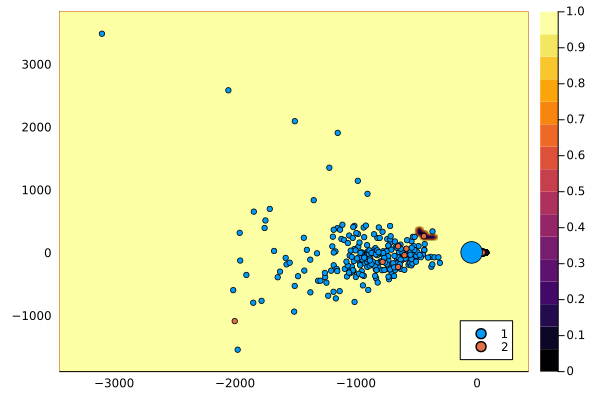

In [9]:
plot(ce)

In [19]:
# propertynames(ce)
# (:x, :target, :target_encoded, :s′, :x′, :data, :M, :generator, :search, 
# :convergence, :num_counterfactuals, :initialization)

In [20]:
factual = vec(ce.x)
counterfactual = vec(ce.x')

df_compare = DataFrame(
    Feature = names(X_combined),
    Factual = factual,
    Counterfactual = counterfactual,
    Différence = counterfactual .- factual
)

Row,Feature,Factual,Counterfactual,Différence
,String,Float32,Float32,Float32
1,Diabetes__No,28.2308,28.2308,0.0
2,Diabetes__Yes,26.6028,26.6028,0.0
3,Smoking__Every day,25.8456,25.8456,0.0
4,Smoking__Not at all,33.2781,33.2781,0.0
5,Smoking__Some days,35.5051,35.5051,0.0
6,Kidney__No,25.0581,25.0581,0.0
7,Kidney__Yes,37.2297,37.2297,0.0
8,Stroke__No,28.478,28.478,0.0
9,Stroke__Yes,24.5606,24.5606,0.0
